In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Importing DeepXDE library for solving partial differential equations using deep learning
import deepxde as dde

# Importing Scikit-Optimize library for Bayesian hyperparameter optimization
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

ModuleNotFoundError: No module named 'deepxde'

In [ ]:
epochs=500

# Theory
Here is the Simplified form of the Burgers' equation with additional higher-order derivatives  

![img1.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/d900cf13fd4877c538ca855b1c7581dc3a4524f2)


---


**Initial Condition** :   
*y(x, 0) = sin((3/5)πx)*  



---


**Dirchilet Boundary Conditions**:

*y(0, t) = 0   
y(10, t) = 0*

# **Define the PDE with boundary conditions**

0 it number
learning rate: 1.0e-03
num_dense_layers: 4
num_dense_nodes: 16
activation: sin
lamda: 0.01

Compiling model...
Building feed-forward neural network...
'build' took 0.070659 s

'compile' took 3.208077 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.42e-01, 6.76e-03, 2.61e-02]    [7.96e-01, 6.76e-03, 2.61e-02]    []  
100       [1.82e-03, 8.84e-05, 7.95e-03]    [1.89e-03, 8.84e-05, 7.95e-03]    []  
200       [3.83e-04, 1.69e-04, 5.18e-03]    [3.47e-04, 1.69e-04, 5.18e-03]    []  
300       [1.67e-04, 1.31e-04, 4.91e-03]    [1.38e-04, 1.31e-04, 4.91e-03]    []  
400       [9.51e-05, 1.08e-04, 4.89e-03]    [8.25e-05, 1.08e-04, 4.89e-03]    []  
500       [6.33e-05, 1.00e-04, 4.88e-03]    [5.97e-05, 1.00e-04, 4.88e-03]    []  

Best model at step 500:
  train loss: 5.05e-03
  test loss: 5.04e-03
  test metric: []

'train' took 20.355989 s

1 it number
learning rate: 2.2e-03
num_dense_layers: 7
num_dens

<Axes: >

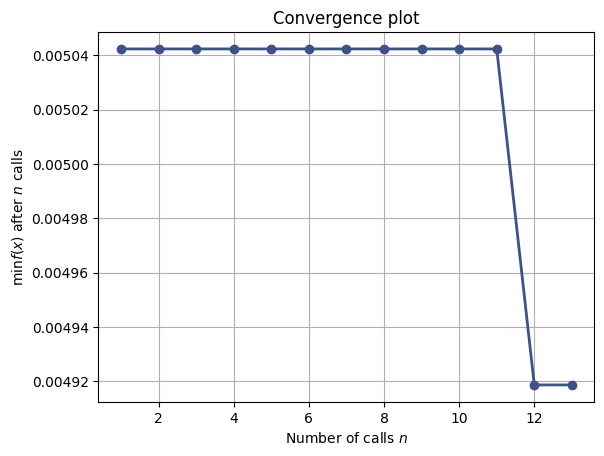

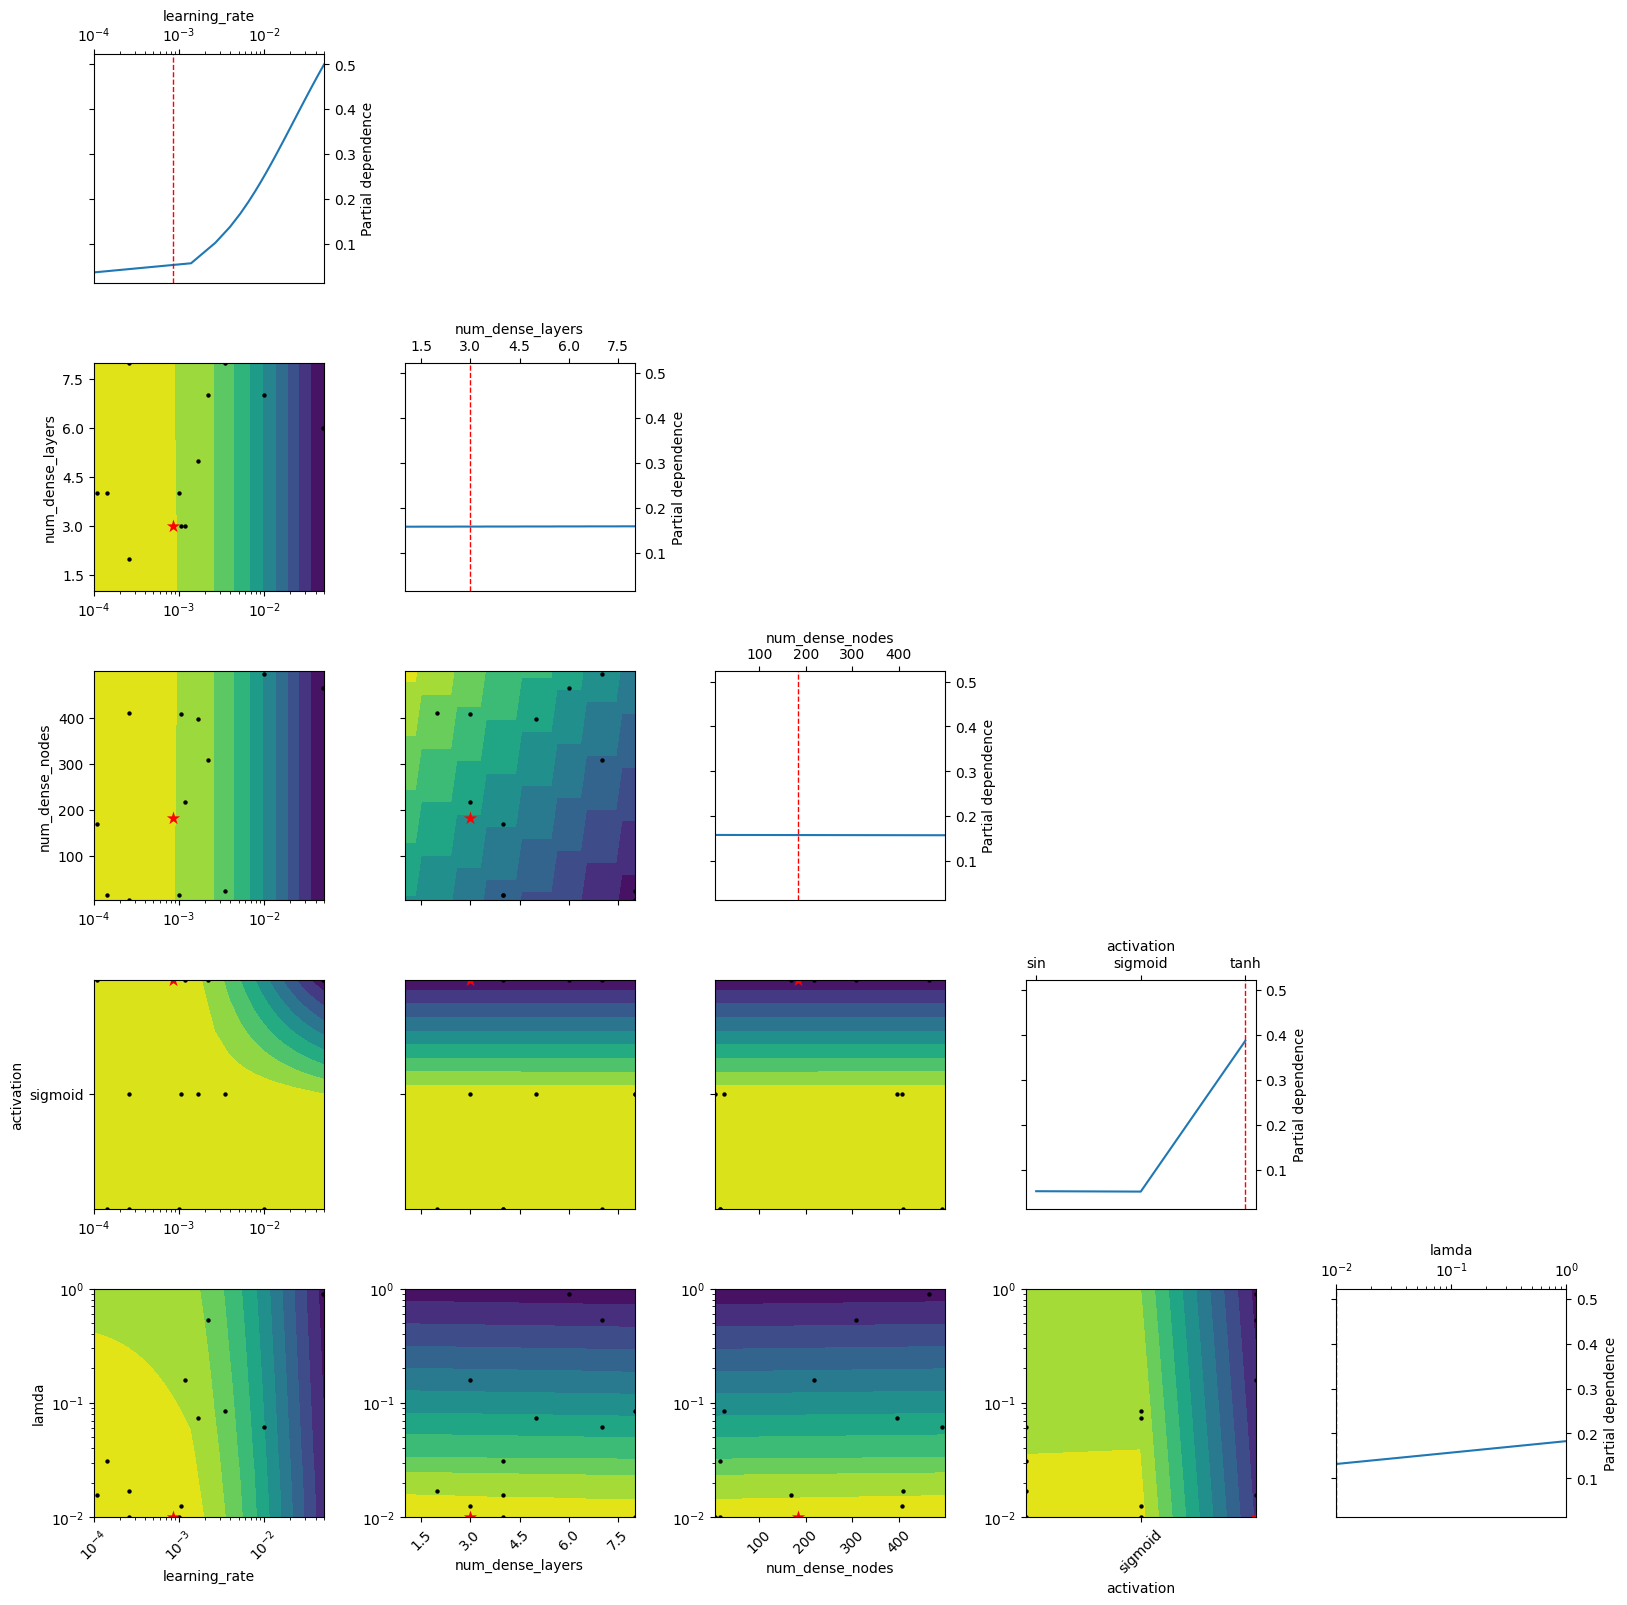

In [ ]:
d=2
epochs=500
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    return dy_t + y * dy_x -  dy_xx


def create_model(config):
    learning_rate, num_dense_layers, num_dense_nodes, activation,lamda = config

    geom = dde.geometry.Interval(0, 10)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(geomtime, lambda x: np.sin((3.0/5)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
    data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=500,  num_boundary=100, num_initial=100,num_test=1000)
    net = dde.maps.FNN(
        [d] + [num_dense_nodes] * num_dense_layers + [1],
        activation,
        "Glorot uniform",
    )

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate,loss_weights=[1, lamda, lamda])
    return model

def train_model(model, config):
    early_stopping = dde.callbacks.EarlyStopping( monitor="loss_train", min_delta=1e-8, patience=100)
    #early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=10)
    losshistory, train_state = model.train(epochs=epochs,disregard_previous_best=True, callbacks=[early_stopping],display_every=100)
    train = np.array(losshistory.loss_train).sum(axis=1).ravel()
    test = np.array(losshistory.loss_test).sum(axis=1).ravel()
    metric = np.array(losshistory.metrics_test).sum(axis=1).ravel()

    error = test.min()
    return error


# HPO setting
n_calls = 13
dim_learning_rate = Real(low=1e-4, high=5e-2, name="learning_rate", prior="log-uniform")
dim_num_dense_layers = Integer(low=1, high=8, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=500, name="num_dense_nodes")
dim_activation = Categorical(categories=["sin", "sigmoid", "tanh"], name="activation")
lamda = Real(low=0.01, high=1, name="lamda", prior="log-uniform")


dimensions = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    lamda
]

default_parameters = [1e-3, 4, 16, "sin",0.01]


@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation,lamda):

    config = [learning_rate, num_dense_layers, num_dense_nodes, activation,lamda]
    global ITERATION

    print(ITERATION, "it number")
    # Print the hyper-parameters.
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print("lamda:", lamda)
    print()

    # Create the neural network with these hyper-parameters.
    model = create_model(config)
    # possibility to change where we save
    error = train_model(model, config)
    # print(accuracy, 'accuracy is')

    if np.isnan(error):
        error = 10**5

    ITERATION += 1
    return error


ITERATION = 0

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func="EI",  # Expected Improvement.
    n_calls=n_calls,
    x0=default_parameters,
    random_state=1234,
)

print(search_result.x)

plot_convergence(search_result)
plot_objective(search_result, show_points=True, size=3.8)



No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.162330 s

'compile' took 2.207221 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.69e-02, 9.79e-01, 2.37e+00]    [2.15e-02, 9.79e-01, 2.37e+00]    []  
1000      [1.38e-02, 2.90e-03, 1.65e-01]    [7.75e-03, 2.90e-03, 1.65e-01]    []  
2000      [1.53e-03, 5.57e-04, 1.08e-03]    [9.58e-04, 5.57e-04, 1.08e-03]    []  

Best model at step 2000:
  train loss: 3.16e-03
  test loss: 2.59e-03
  test metric: []

'train' took 19.371430 s



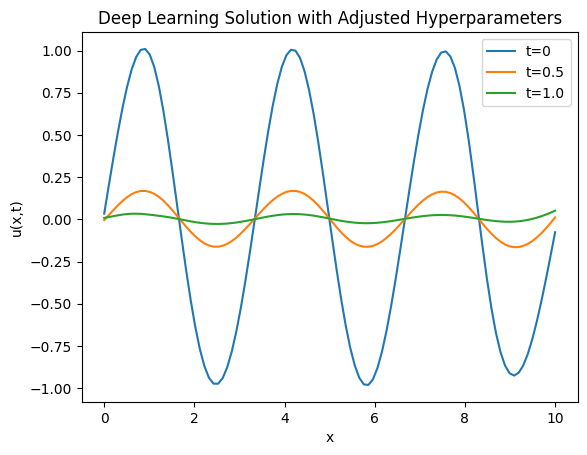

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# PDE and Initial Conditions as defined before
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - dy_xx

# Geometry and time domain
geom = dde.geometry.Interval(0, 10)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary and Initial Conditions
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: np.sin((3.0/5)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Data configuration
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=500, num_boundary=100, num_initial=100, num_test=1000)

# Adjusted neural network configuration
# Increased the number of nodes and layers, also changed the activation function to "tanh"
net = dde.maps.FNN([2] + [64] * 6 + [1], "tanh", "Glorot uniform")  # Larger network

# Compile the model with an adjusted learning rate and use "Adam" optimizer
model = dde.Model(data, net)
model.compile("adam", lr=5e-4)  # Decreased learning rate

# Train the model for more epochs
losshistory, train_state = model.train(epochs=2000)  # Increased number of epochs

# Generate predictions for specific time steps t = 0, t = 0.5, t = 1.0
x = np.linspace(0, 10, 100).reshape(-1, 1)
t_0 = np.zeros_like(x)
t_05 = np.ones_like(x) * 0.5
t_1 = np.ones_like(x) * 1.0

# Predict the solution at t = 0, t = 0.5, t = 1.0
X_0 = np.hstack((x, t_0))
X_05 = np.hstack((x, t_05))
X_1 = np.hstack((x, t_1))

u_pred_0 = model.predict(X_0)
u_pred_05 = model.predict(X_05)
u_pred_1 = model.predict(X_1)

# Plot the solutions
plt.plot(x, u_pred_0, label='t=0')
plt.plot(x, u_pred_05, label='t=0.5')
plt.plot(x, u_pred_1, label='t=1.0')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.title('Deep Learning Solution with Adjusted Hyperparameters')
plt.show()



In [ ]:
++++++++++

```Matlab```
```
clear all; close all; clc;

% Construct spatial mesh
Nx = 100;           % Number of spatial steps
xl = 0;             % Left x boundary
xr = 10;            % Right x boundary
dx = (xr-xl)/Nx;    % Spatial step
x = xl:dx:xr;       % x

% Construct temporal mesh
tf = 1;             % Final time
dt = 0.0072;        % Timestep
Nt = round(tf/dt);  % Number of timesteps
t = 0:dt:tf;        % t

% Parameters
umax = 15;                      % Found by a perturbation of t=10^-2
C = umax*dt/dx;                 % Courant Number
V = dt/(dx*dx);                 % Diffusion Number

% Define Boundary & Initial Conditions
for j = 1:Nt+1
  u(1,j) = 0;  % u(0,t) = 0 (Left boundary)
  u(Nx+1,j) = 0; % u(10,t) = 0 (Right boundary)
end

% Initial condition (t = 0)
function u0 = initial_condition(x)
  u0 = sin((3.0/5)*pi * x);
end

for i = 1:Nx+1
  u(i,1) = initial_condition(x(i));
end

% Define the MMl and MMr matrices in Crank-Nicolson method
aal(1:Nx-2) = -V;                   
bbl(1:Nx-1) = 2+2*V;                
ccl(1:Nx-2) = -V;                   
MMl = diag(bbl,0)+diag(aal,-1)+diag(ccl,1);

aar(1:Nx-2) = V;                    
bbr(1:Nx-1) = 2-2*V;                
ccr(1:Nx-2) = V;                    
MMr = diag(bbr,0)+diag(aar,-1)+diag(ccr,1);

% Implement Crank-Nicolson method
for j = 1:Nt                        
    u(2:Nx,j+1) = inv(MMl)*MMr*u(2:Nx,j);   
end

% Plot solution at t = 0, t = 0.5, t = 1.0
figure;
hold on;
plot(x, u(:,1), 'DisplayName', 't=0');
plot(x, u(:,round(0.5/dt)), 'DisplayName', 't=0.5');
plot(x, u(:,end), 'DisplayName', 't=1.0');
xlabel('x');
ylabel('u(x,t)');
legend show;
title('Crank-Nicolson Solution of Burger''s PDE');
saveas(gcf, 'img.png');

```

Solution from above Crank Nicolson scheme for different values of t is

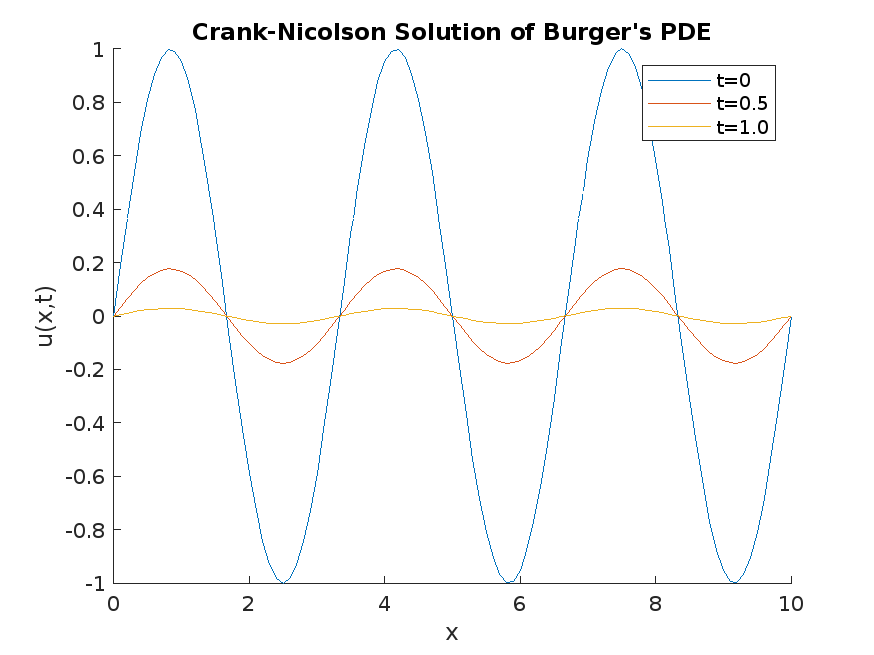